# Function

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import mutual_info_classif
import plotly.graph_objs as go

In [2]:
# in common use
def min_max_normalization(data):
    return (data - np.min(data, axis = 0))/(np.max(data, axis = 0) - np.min(data, axis = 0))

def concatenate_two_1D_array(X1,X2):
    return np.concatenate((X1.reshape(len(X1),1),X2.reshape(len(X2),1)),axis=1)

def sort_by_row_in_2D_array_descending(X,row_number):
    ind = np.argsort(-X[:,row_number])
    return X[ind,:]

def select_feature(X,selected_feature):
    return X[:,selected_feature]

def accuracy(y,y_pred):
    return sum(y_pred == y)/len(y_pred == y)

def save_ndarray_to_csv(X,filename):
    X = pd.DataFrame(X)
    X.to_csv("{}.csv".format(filename), index=True)

In [3]:
# split categorical feature and continuous feature
# judge
def Is_Continuous(X_train, unique_value_threshold):
    return np.array([len(np.unique(X_train[:,i])) > unique_value_threshold for i in range(X_train.shape[1])])

# check len unique
def check_len_unique(X_train):
    len_unique = np.zeros(X_train.shape[1])
    for i in range(X_train.shape[1]):
        len_unique[i] = len(np.unique(X_train[:, i]))
    return len_unique

In [4]:
# RELIEF-F
from sklearn.neighbors import NearestNeighbors

def diff(x_1,x_2,is_categorical):
    if is_categorical == True: # categorical
        if x_1 == x_2:
            return 0
        if x_1 != x_2:
            return 1
    if is_categorical == False: # continuous
        return np.abs(x_1 - x_2)

def reliefF(X_train, y_train, n_neighbors, is_categorical):
    
    # prepare
    n_samples, n_features = X_train.shape
    weight_of_feature = np.zeros(n_features)

    # get the frequency of each label in y_train
    counts = np.bincount(y_train)
    frequency = counts / y_train.shape
    
    # use NearestNeighbors of sklearn to get enough neighbors
    n_multiple = 10 # With lab5's ball-like bad data, 10x is enough
    neigh = NearestNeighbors(n_neighbors = n_neighbors * len(counts) * n_multiple + 1, metric='minkowski', p = 1) # len(counts) = 4
    neigh.fit(X_train)
    _, hit_miss_indices = neigh.kneighbors(X_train)
    hit_miss_indices = hit_miss_indices[:, 1:]
    
    # for each sample i
    for i in range(n_samples):

        # get hit indices, the amount equals n_neighbors
        hit_indices = hit_miss_indices[i][y_train[hit_miss_indices[i]] == y_train[i]]
        if len(hit_indices) < n_neighbors:
            raise ValueError("length of hit_indices is less than n_neighbors")
        else:
            hit_indices = hit_indices[0:n_neighbors]
        
        # get miss indices, the amount equals n_neighbors for each miss class
        miss_indices = hit_miss_indices[i][y_train[hit_miss_indices[i]] != y_train[i]]        
        miss_label = y_train[miss_indices]
        miss_ind_and_label = np.concatenate((miss_indices.reshape(len(miss_indices),1),miss_label.reshape(len(miss_label),1)),axis=1)
        label = np.unique(miss_ind_and_label[:,1])
        count = np.zeros(len(label))
        delete = []        
        for k in range(miss_ind_and_label.shape[0]): # for each row k of miss_ind_and_label
            for l in range(len(label)): # len(label) is the number of class in y_train minus 1
                if miss_ind_and_label[k,1] == label[l]:
                    count[l] += 1
                    if count[l] >= n_neighbors + 1:
                        delete.append(k)
        miss_ind_and_label = np.delete(miss_ind_and_label, delete, axis = 0)
        if miss_ind_and_label.shape[0] != (len(label))*n_neighbors:
            raise ValueError("length of miss_indices is less than n_neighbors")
        miss_indices = miss_ind_and_label[:,0]

        # for each feature j
        for j in range(n_features):
            for hit_idx in hit_indices:      
                weight_of_feature[j] -= diff(X_train[i, j],X_train[hit_idx, j],is_categorical[j]) / n_neighbors
            for miss_idx in miss_indices:
                weight_of_miss = frequency[y_train[miss_idx]]/(1 - frequency[y_train[i]]) # calculate weighted average of miss classes
                weight_of_feature[j] += diff(X_train[i, j],X_train[miss_idx, j],is_categorical[j]) / n_neighbors * weight_of_miss

    return weight_of_feature

In [5]:
# I mutual
def run_many_times_for_continuous_features_to_calculate_I_mutual(X_train_continuous_features,y_train,n_sample,n_loop,n_continuous):
    I_mutual_sum = np.zeros(n_continuous)
    for i in range(n_loop):
        df = np.concatenate((X_train_continuous_features, y_train.reshape(len(y_train),1)), axis = 1)
        np.random.shuffle(df)
        df = df[0:n_sample, :]
        discrete_vars = np.zeros((n_continuous,), dtype=bool)
        I_mutual = mutual_info_classif(df[:,0:n_continuous], df[:,n_continuous], discrete_features = discrete_vars)
        I_mutual_sum = I_mutual_sum + I_mutual
    I_mutual_average = I_mutual_sum / n_loop
    return I_mutual_average

# you may use this function if you choose more categorical features than 23
def discretize_by_decimal_place(categorical_features, decimal_places):
    categorical_features_rounded = np.round(categorical_features, decimal_places)
    return categorical_features_rounded

In [6]:
# visualization
def plot_2D(train_feature_2D, train_label):

    # concatenate to stain the dots
    df = np.concatenate((train_feature_2D, train_label), axis=1)

    # plot
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    colors_list = ["r", "g", "b", "k"]
    ax1.scatter(df[:, 0], df[:, 1], c=[colors_list[int(i)] for i in df[:, 2]])

def plot_3D(train_feature_3D, train_label):

    x = train_feature_3D[:, 0]
    y = train_feature_3D[:, 1]
    z = train_feature_3D[:, 2]
    colors = ['red' if label == 0 else 'blue' if label == 1 else 'green' if label == 2 else 'black' for label in train_label]

    trace = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            color=colors,
            size=12,
            symbol='circle',
            line=None,
            opacity=0.9
        )
    )
    data = [trace]

    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )

    fig = go.Figure(data=data, layout=layout)

    fig.update_layout(
        title="3D Scatter Plot",
        scene = dict(
            xaxis_title='X-axis',
            yaxis_title='Y-axis',
            zaxis_title='Z-axis'
        )
    )

    fig.show()

# Load Dataset

In [7]:
# read
train_feature = pd.read_csv('Dataset/train_feature.csv')
train_null = train_feature.isnull().sum() # Checking the Missing Values (nan)
train_describe = train_feature.describe() # descriptive statistics

test_feature = pd.read_csv('Dataset/test_feature.csv')
test_null = test_feature.isnull().sum() # Checking the Missing Values (nan)
test_describe = test_feature.describe() # descriptive statistics

train_label = pd.read_csv('Dataset/train_label.csv')
train_label_count = train_label.value_counts() # count different label

# to numpy
train_feature = train_feature.to_numpy() 
test_feature = test_feature.to_numpy()
train_label = train_label.to_numpy()

# Preprocess

## process nan

In [8]:
# use median to take the place of nan
def nan_to_median(train_feature):
    median = np.nanmedian(train_feature, axis = 0)
    for i in range(train_feature.shape[1]):
        train_feature[:, i] = np.where(np.isnan(train_feature[:, i]), median[i], train_feature[:, i])

# process train_feature and test_feature
nan_to_median(train_feature)
nan_to_median(test_feature)

## process outliers

### Tukey test

In [9]:
def Tukey_test(train_feature, IQR_index):
    upper_percentile = 75
    lower_percentile = 25
    upper_bound = np.percentile(train_feature, upper_percentile, axis=0)
    lower_bound = np.percentile(train_feature, lower_percentile, axis=0)
    IQR = upper_bound - lower_bound    
    up_limit = upper_bound + IQR * IQR_index
    down_limit = lower_bound - IQR * IQR_index
    mask = np.logical_and(train_feature >= down_limit, train_feature <= up_limit) # mask is normal, ~mask is outlier
    number_of_outliers = np.sum(~mask)
    return number_of_outliers, mask

#### decide IQR index for Tukey test
* method 1: draw graph of number of outliers versus IQR index
* method 2: compare IQR index by seeing Jupyter variables
* method 3: draw histograms of all features

method 1: draw graph of number of outliers versus IQR index

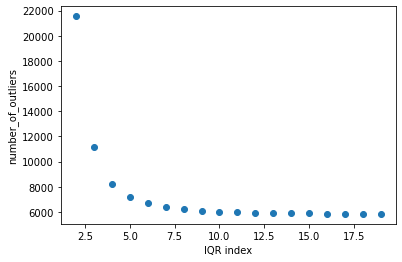

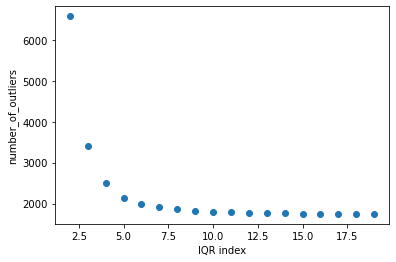

In [10]:
def plot_number_of_outliers_vs_IQR_index(train_feature, IQR_index_max):

    # draw graph of number of outliers versus IQR index
    count = 0
    x = np.arange(2,IQR_index_max,1)
    number_of_outliers = np.zeros(x.size)
    for IQR_index in x:
        number_of_outliers[count], _ = Tukey_test(train_feature, IQR_index)
        count = count + 1
    fig = plt.figure() 
    ax1 = fig.add_subplot(111)
    plt.xlabel('IQR index') 
    plt.ylabel('number_of_outliers') 
    ax1.scatter(x, number_of_outliers)

    # create a table of x and number_of_outliers to see them more conveniently
    table = np.zeros((len(x),2))
    table[:,0] = x
    table[:,1] = number_of_outliers
    return table

# train_feature
IQR_index_max = 20
table_train = plot_number_of_outliers_vs_IQR_index(train_feature, IQR_index_max)

# test_feature
IQR_index_max = 20
table_test = plot_number_of_outliers_vs_IQR_index(test_feature, IQR_index_max)

method 2: compare IQR index by seeing Jupyter variables

In [11]:
def outliers_to_median(train_feature, IQR_index): # shallow replicate
    _, mask = Tukey_test(train_feature, IQR_index) 
    median = np.nanmedian(train_feature, axis = 0)
    for i in range(train_feature.shape[1]):
        train_feature[:, i] = np.where(mask[:,i], train_feature[:, i], median[i]) # mask is normal, ~mask is outlier
    return train_feature

# check outliers and normal values or train_feature and test_feature

# train_feature

# train_feature_7 = train_feature.copy()
# IQR_index = 7
# _ = outliers_to_median(train_feature_7, IQR_index)

# train_feature_10 = train_feature.copy()
# IQR_index = 10
# _ = outliers_to_median(train_feature_10, IQR_index)

# train_feature_15 = train_feature.copy()
# IQR_index = 15
# _ = outliers_to_median(train_feature_15, IQR_index)

# train_feature_20 = train_feature.copy()
# IQR_index = 20
# _ = outliers_to_median(train_feature_20, IQR_index)

# test_feature

# test_feature_7 = test_feature.copy()
# IQR_index = 7
# _ = outliers_to_median(test_feature_7, IQR_index)

# test_feature_10 = test_feature.copy()
# IQR_index = 10
# _ = outliers_to_median(test_feature_10, IQR_index)

# test_feature_15 = test_feature.copy()
# IQR_index = 15
# _ = outliers_to_median(test_feature_15, IQR_index)

# test_feature_20 = test_feature.copy()
# IQR_index = 20
# _ = outliers_to_median(test_feature_20, IQR_index)

method 3: draw histograms of all features

In [12]:
def histogram_all_features(train_feature, filename): # you must create a file named filename in this name before using this function
    for i in range(train_feature.shape[1]):
        plt.hist(train_feature[:, i], density=False,
                bins=30, facecolor="blue", edgecolor="black")
        plt.xlabel('feature %i' % i)
        plt.ylabel('count')
        plt.savefig('{}/fig_{}.png'.format(filename, i))
        plt.cla()
        
def decide_by_hist(train_feature, IQR_index):
    train_feature = train_feature.copy() # create a copy of the array, in this way, you can make a deep replicate instead of a shallow replicate
    train_feature = outliers_to_median(train_feature, IQR_index)
    histogram_all_features(train_feature, 'IQR_index_{}'.format(IQR_index))

# check outliers and normal values of train_feature and test_feature by histogram

# train_feature
# IQR_index = 7
# decide_by_hist(train_feature, IQR_index)

# test_feature
# IQR_index = 7
# decide_by_hist(test_feature, IQR_index)

### replace outliers

In [13]:
# IQR_index is a hyper-parameter
IQR_index = 15

# train_feature
train_feature = outliers_to_median(train_feature, IQR_index)

# test_feature
test_feature = outliers_to_median(test_feature, IQR_index)

# Calculate Pearson correlation matrix of features

In [14]:
temp = pd.DataFrame(train_feature)

In [15]:
corr_matrix = temp.corr()

In [16]:
# 根据每一行中绝对值大于 0.7 的元素个数排序，打印前面十项
sort_order = corr_matrix.abs().gt(0.7).sum(axis=1).sort_values(ascending=False)
for i in sort_order.index[:10]:
    print("Index: ", i, ", Count: ", sort_order[i])

Index:  69 , Count:  4
Index:  92 , Count:  4
Index:  5 , Count:  4
Index:  73 , Count:  4
Index:  89 , Count:  2
Index:  50 , Count:  2
Index:  82 , Count:  1
Index:  79 , Count:  1
Index:  80 , Count:  1
Index:  81 , Count:  1


# Split

In [17]:
from sklearn.model_selection import train_test_split
X = train_feature
y = train_label

# 2 split
# Indeed I use 3 split, not 2 split, because afterwards I will use cross-validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
# reshape
y_train = y_train.reshape(len(y_train),)
y_test = y_test.reshape(len(y_test),)

# number of samples and features in train set
n_sample_of_train_set = X_train.shape[0]
n_feature = X_train.shape[1]

# Normalization

split all features into the continuous and the categorical

In [19]:
# split
threshold_of_unique_value = 23 # a hyper-parameter
is_continuous = Is_Continuous(X_train, threshold_of_unique_value)
is_categorical = ~is_continuous
X_train_continuous_features = X_train[:, is_continuous]
X_train_categorical_features = X_train[:, ~is_continuous]

# store original rank
original_rank_continuous = np.where(is_continuous)[0]
original_rank_categorical = np.where(~is_continuous)[0]

# number of continuous features and categorical features in train set
n_continuous = X_train_continuous_features.shape[1]
n_categorical = X_train_categorical_features.shape[1]

In [20]:
# min-max-normalization
X_train = min_max_normalization(X_train)
X_test = min_max_normalization(X_test)

In [21]:
test_feature = min_max_normalization(test_feature)

# Feature Selection

## filter method

### RELIEF-F

In [22]:
# RELIEF-F
n_neigh_RELIEF = 10 # hyper-parameter
weight_of_feature = reliefF(X_train, y_train, n_neigh_RELIEF, is_categorical)
weight_of_feature_concatenate = concatenate_two_1D_array(weight_of_feature,np.arange(120))
weight_of_feature_concatenate = sort_by_row_in_2D_array_descending(weight_of_feature_concatenate,0)

# get index of selected feature
n_choose_RELIEF = 20 # a hyper-parameter
selected_feature_RELIEF = weight_of_feature_concatenate[0:n_choose_RELIEF,1]
selected_feature_RELIEF = selected_feature_RELIEF.astype(int)
selected_feature_RELIEF = np.sort(selected_feature_RELIEF)

KNN

In [23]:
# # knn
# n_choose = 20
# result_knn = np.zeros((n_choose*n_neigh_RELIEF,3))
# count = 0
# for i in range(1,n_choose,1):

#     # select top i features
#     selected_feature = weight_of_feature_concatenate[0:i,1]
#     selected_feature = selected_feature.astype(int)
#     selected_feature = np.sort(selected_feature)
#     X_train_RELIEF = select_feature(X_train,selected_feature)
#     X_test_RELIEF = select_feature(X_test,selected_feature)

#     # perform knn
#     for n_neigh_knn in np.arange(1,n_neigh_RELIEF + 1,1):
#         knn = KNeighborsClassifier(n_neighbors=n_neigh_knn,p = 1,metric = 'minkowski')
#         knn.fit(X_train_RELIEF, y_train)
#         y_val_pred = knn.predict(X_test_RELIEF)
#         result_knn[count,0] = i
#         result_knn[count,1] = n_neigh_knn
#         result_knn[count,2] = accuracy(y_test,y_val_pred)
#         count += 1

### chi2

1 time

In [24]:
# # make chi2 test between each column of X and y

# # def
# from scipy.stats import chi2_contingency
# def chi2_test(X, y):
#     chi2_value = []
#     p_value = []
#     degree_of_freedom = []
#     for i in range(X.shape[1]):
#         result = chi2_contingency(pd.crosstab(X[:, i], y))
#         chi2_value.append(result[0])
#         p_value.append(result[1])
#         degree_of_freedom.append(result[2])
#     number_of_unique_value = np.array(degree_of_freedom) / 3 # to get unique sample count
#     return chi2_value, p_value, number_of_unique_value

# # chi 2 for categorical feature
# chi2_value_categorical_all_sample, p_value_categorical_all_sample, number_of_unique_value_categorical_all_sample \
#      = chi2_test(categorical_features, train_label.reshape(train_label.shape[0]))

# # chi 2 for continuous feature
# decimal_places = 2 # a hyper-parameter # this is consistent with the 100 threshold of categarical features
# continuous_features_rounded = discretize_by_decimal_place(continuous_features, decimal_places)
# chi2_value_continuous_all_sample, p_value_continuous_all_sample, number_of_unique_value_continuous_all_sample \
#      = chi2_test(continuous_features_rounded, train_label.reshape(train_label.shape[0]))

multi times

In [25]:
# n_sample = 5000 # hyper-parameter # 5000 means 50 for each category
# n_continuous = categorical_features.shape[1]
# rank_sum = np.zeros(n_continuous)
# for i in range(10):
#     # shuffle
#     df = np.concatenate((categorical_features, train_label), axis = 1)
#     np.random.shuffle(df)
#     df = df[0:n_sample, :]

#     # chi2 test
#     _, p_value_of_1_Fold, _ = chi2_test(df[:, 0:df.shape[1]-1], df[:, df.shape[1]-1])

#     # add rank
#     p_value_of_1_Fold = np.array(p_value_of_1_Fold)
#     serial_number = np.arange(n_continuous)
#     p_value_of_1_Fold = np.concatenate((serial_number.reshape(n_continuous,1), p_value_of_1_Fold.reshape(n_continuous,1)), axis = 1)
#     ind = np.argsort(p_value_of_1_Fold[:,1])
#     p_value_of_1_Fold = p_value_of_1_Fold[ind]
#     rank = np.arange(n_continuous).reshape(n_continuous,1) + 1
#     p_value_of_1_Fold = np.concatenate((p_value_of_1_Fold, rank), axis = 1)
#     ind = np.argsort(p_value_of_1_Fold[:,0])
#     p_value_of_1_Fold = p_value_of_1_Fold[ind]
#     rank_sum = rank_sum + p_value_of_1_Fold[:,2]

# sorted_rank_sum = np.sort(rank_sum)
# plt.plot(sorted_rank_sum)
# plt.show()

### mutual information

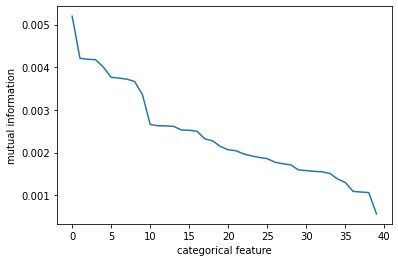

KeyboardInterrupt: 

In [26]:
# categorical feature
discrete_vars_categorical = np.ones((n_categorical,), dtype=bool)
I_mutual_categorical = mutual_info_classif(X_train_categorical_features, y_train.reshape(y_train.shape[0],), discrete_features = discrete_vars_categorical)
plt.plot(-np.sort(-I_mutual_categorical))
plt.xlabel('categorical feature')
plt.ylabel('mutual information')
plt.show()
I_mutual_categorical = concatenate_two_1D_array(original_rank_categorical,I_mutual_categorical)

# continuous feature
n_loop = 100
I_mutual_continuous_average = run_many_times_for_continuous_features_to_calculate_I_mutual(X_train_continuous_features,y_train,n_sample_of_train_set,n_loop,n_continuous)
plt.plot(-np.sort(-I_mutual_continuous_average))
plt.xlabel('continuous feature')
plt.ylabel('mutual information')
plt.show()
I_mutual_continuous_average = concatenate_two_1D_array(original_rank_continuous,I_mutual_continuous_average)

# get index of selected feature
I_mutual = np.concatenate((I_mutual_categorical,I_mutual_continuous_average))
I_mutual = sort_by_row_in_2D_array_descending(I_mutual,1)
n_choose_I_mutual = 10 # a hyper-parameter
selected_feature_I_mutual = I_mutual[0:n_choose_I_mutual,0]
selected_feature_I_mutual = selected_feature_I_mutual.astype(int)
selected_feature_I_mutual = np.sort(selected_feature_I_mutual)

# union1d
selected_feature = np.union1d(selected_feature_RELIEF,selected_feature_I_mutual)

## wrapper method

In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.feature_selection import RFE

# # fit
# clf_LR = LogisticRegression(multi_class="multinomial", solver='lbfgs', max_iter=10 ** 3)
# selector = RFE(estimator = clf_LR, step = 1, n_features_to_select = 10)
# selector.fit(X_train_RELIEF_I_mutual, y_train)
# X_train_rfe = selector.transform(X_train_RELIEF_I_mutual)
# X_validation_rfe = selector.transform(X_val_RELIEF_I_mutual)

# # test the transformed data

# # fit
# clf_LR.fit(X_train_rfe, y_train)

# # coef and intercept
# a = clf_LR.coef_
# b = clf_LR.intercept_

# # accuracy of train set
# y_train_pred = clf_LR.predict(X_train_rfe)
# print("accuracy of train set: {}".format(accuracy(y_train,y_train_pred)))

# # accuracy of validation set
# y_validation_pred = clf_LR.predict(X_validation_rfe)
# print("accuracy of validation set: {}".format(accuracy(y_val,y_validation_pred)))

## embed method

### LASSO

In [ ]:
# from sklearn.linear_model import Lasso
# from sklearn.multiclass import OneVsRestClassifier
# lasso = Lasso(alpha = 0.1)
# clf = OneVsRestClassifier(lasso)
# clf.fit(X_train_RELIEF_I_mutual, y_train)

# # accuracy of train set
# y_train_pred = clf.predict(X_train_RELIEF_I_mutual)
# print("accuracy of train set: {}".format(accuracy(y_train,y_train_pred)))

# # accuracy of validation set
# y_val_pred = clf.predict(X_val_RELIEF_I_mutual)
# print("accuracy of validation set: {}".format(accuracy(y_val,y_val_pred)))

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score

In [ ]:
# choose 30 features
X_train_RELIEF_I_mutual = X_train[:,selected_feature]
X_test_RELIEF_I_mutual = X_test[:,selected_feature]

In [ ]:
DT = DecisionTreeClassifier(random_state = 66)
score = cross_val_score(DT,X_train_RELIEF_I_mutual,y_train,cv=4).mean()
print('基尼系数得分: %.4f'%score)
DT = DecisionTreeClassifier(criterion = 'entropy',random_state = 66)
score = cross_val_score(DT,X_train_RELIEF_I_mutual,y_train,cv=4).mean()
print('熵得分: %.4f'%score)

So I choose gini index.

In [ ]:
###在大范围内画出max_depth这个参数变化曲线
ScoreAll = []
for i in range(10,100,10):
    DT = DecisionTreeClassifier(max_depth = i,random_state = 66)
    score = cross_val_score(DT,X_train_RELIEF_I_mutual,y_train,cv=4).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0]
print("最优参数以及最高得分:",ScoreAll[max_score])  
plt.figure(figsize=[20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

In [ ]:
###在小范围内画出max_depth这个参数变化曲线
ScoreAll = []
for i in range(20,40,1):
    DT = DecisionTreeClassifier(max_depth = i,random_state = 66)
    score = cross_val_score(DT,X_train_RELIEF_I_mutual,y_train,cv=4).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0]
print("最优参数以及最高得分:",ScoreAll[max_score])  
plt.figure(figsize=[20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

暂定31

In [ ]:
#单独看看min_samples_split的变化趋势
ScoreAll = []
for i in range(2,30):
    DT = DecisionTreeClassifier(max_depth = 31,min_samples_split = i,random_state = 66)
    score = cross_val_score(DT,X_train_RELIEF_I_mutual,y_train,cv=4).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0] ##这句话看似很长的，其实就是找出最高得分对应的索引
print("最优参数以及最高得分:",ScoreAll[max_score])  
# print(ScoreAll[,0])
plt.figure(figsize=[20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

暂定6

In [ ]:
###调min_samples_leaf这个参数
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

ScoreAll = []
for i in range(1,30):
    DT = DecisionTreeClassifier(min_samples_leaf = i,min_samples_split = 6,max_depth = 31,random_state = 66)
    score = cross_val_score(DT,X_train_RELIEF_I_mutual,y_train,cv=4).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0] ##这句话看似很长的，其实就是找出最高得分对应的索引
print("最优参数以及最高得分:",ScoreAll[max_score])  
# print(ScoreAll[,0])
plt.figure(figsize=[20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

根据我们前边的一系列操作，我们确定因为max_depth在31附近，min_samples_split在6附近，min_samples_leaf在1附近是最优参数。

In [ ]:
#max_depth、min_samples_leaf和min_samples_split一块儿调整  
param_grid = {
    'max_depth':np.arange(25, 35),
    'min_samples_leaf':np.arange(1, 10),
    'min_samples_split':np.arange(1, 10)}

rfc = DecisionTreeClassifier(random_state=66)
GS = GridSearchCV(rfc,param_grid,cv=4)
GS.fit(X_train_RELIEF_I_mutual,y_train)
print(GS.best_params_)
print(GS.best_score_)

In [ ]:
results = GS.cv_results_
my_mean_list = []
my_std_list = []
my_params_list = []

for mean, std, params in zip(results['mean_test_score'], results['std_test_score'], results['params']):
    my_mean_list.append(mean)
    my_std_list.append(std)
    my_params_list.append(params)

my_mean_list = np.array(my_mean_list).reshape(len(my_mean_list),1)
my_std_list = np.array(my_std_list).reshape(len(my_std_list),1)
my_params_list_2 = pd.DataFrame(my_params_list)
my_params_list_2 = my_params_list_2.to_numpy()
my_GS_result = np.concatenate((my_mean_list,my_std_list),axis=1)
my_GS_result = np.concatenate((my_GS_result,my_params_list_2),axis=1)
save_ndarray_to_csv(my_GS_result,'GS_result')

综合考虑mean和std，选择31、1、6

In [ ]:
DT = DecisionTreeClassifier(min_samples_leaf = 1,min_samples_split = 6,max_depth = 31,random_state = 66)
score = cross_val_score(DT,X_train_RELIEF_I_mutual,y_train,cv=4).mean()
print(score)

In [ ]:
X_cv = X_train_RELIEF_I_mutual
y_cv = y_train
from sklearn.model_selection import StratifiedKFold
k = 4 # a hyper-parameter
stratified_kf = StratifiedKFold(n_splits = k)
importance_DT = np.zeros((len(selected_feature),))
y_train_acc_sum = 0
y_val_acc_sum = 0
for train_index, val_index in stratified_kf.split(X_cv, y_cv):
    
    # split
    X_train_cv, X_val_cv = X_cv[train_index], X_cv[val_index]
    y_train_cv, y_val_cv = y_cv[train_index], y_cv[val_index]

    # fit
    DT = DecisionTreeClassifier(min_samples_leaf = 1,min_samples_split = 6,max_depth = 31,random_state = 66)
    DT.fit(X_train_cv, y_train_cv)
    # train
    y_train_pred = DT.predict(X_train_cv)
    y_train_acc = accuracy(y_train_cv,y_train_pred)
    print("accuracy of train set: {}".format(y_train_acc))
    # val
    y_val_pred = DT.predict(X_val_cv)
    y_val_acc = accuracy(y_val_cv,y_val_pred)
    print("accuracy of validation set: {}".format(y_val_acc))
    # importance
    importance_DT += DT.feature_importances_
    # sum
    y_train_acc_sum += y_train_acc
    y_val_acc_sum += y_val_acc

# print
y_train_acc_average = y_train_acc_sum / 4
print("average accuracy of train set: {}".format(y_train_acc_average))
y_val_acc_average = y_val_acc_sum / 4
print("average accuracy of val set: {}".format(y_val_acc_average))

# plot
plt.plot(-np.sort(-importance_DT))
plt.xlabel('feature')
plt.ylabel('importance of decision tree')
plt.show()

In [ ]:
# feature selection
importance_DT = concatenate_two_1D_array(np.arange(len(importance_DT)),importance_DT)
importance_DT = sort_by_row_in_2D_array_descending(importance_DT,1)
n_choose = 28
temp = importance_DT[0:n_choose,0]
temp = temp.astype(int)
selected_feature_v2 = selected_feature[temp]
selected_feature_v2 = np.sort(selected_feature_v2)

测试集准确率（严格来说，我做完这一点之后就不可以进行任何操作，当然也不可以进行下一轮特征选择）

In [ ]:
DT = DecisionTreeClassifier(min_samples_leaf = 1,min_samples_split = 6,max_depth = 31,random_state = 66)
DT.fit(X_train_RELIEF_I_mutual, y_train)
y_test_pred = DT.predict(X_test_RELIEF_I_mutual)
accuracy(y_test,y_test_pred)

预测test_label

In [ ]:
y_test_feature_pred = DT.predict(test_feature[:,selected_feature])
save_ndarray_to_csv(y_test_feature_pred,'test_label')

### Decision Tree_round 2

In [ ]:
# choose 16 features
X_train_RELIEF_I_mutual_DT = X_train[:,selected_feature_v2]
X_test_RELIEF_I_mutual_DT = X_test[:,selected_feature_v2]

In [ ]:
DT = DecisionTreeClassifier(random_state = 66)
score = cross_val_score(DT,X_train_RELIEF_I_mutual_DT,y_train,cv=4).mean()
print('基尼系数得分: %.4f'%score)
DT = DecisionTreeClassifier(criterion = 'entropy',random_state = 66)
score = cross_val_score(DT,X_train_RELIEF_I_mutual_DT,y_train,cv=4).mean()
print('熵得分: %.4f'%score)

So I choose gini index.

In [ ]:
###在大范围内画出max_depth这个参数变化曲线
ScoreAll = []
for i in range(10,100,10):
    DT = DecisionTreeClassifier(max_depth = i,random_state = 66)
    score = cross_val_score(DT,X_train_RELIEF_I_mutual_DT,y_train,cv=4).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0]
print("最优参数以及最高得分:",ScoreAll[max_score])  
plt.figure(figsize=[20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

In [ ]:
###在小范围内画出max_depth这个参数变化曲线
ScoreAll = []
for i in range(20,40,1):
    DT = DecisionTreeClassifier(max_depth = i,random_state = 66)
    score = cross_val_score(DT,X_train_RELIEF_I_mutual_DT,y_train,cv=4).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0]
print("最优参数以及最高得分:",ScoreAll[max_score])  
plt.figure(figsize=[20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

暂定31

In [ ]:
#单独看看min_samples_split的变化趋势
ScoreAll = []
for i in range(2,30):
    DT = DecisionTreeClassifier(max_depth = 31,min_samples_split = i,random_state = 66)
    score = cross_val_score(DT,X_train_RELIEF_I_mutual_DT,y_train,cv=4).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0] ##这句话看似很长的，其实就是找出最高得分对应的索引
print("最优参数以及最高得分:",ScoreAll[max_score])  
# print(ScoreAll[,0])
plt.figure(figsize=[20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

暂定8

In [ ]:
###调min_samples_leaf这个参数
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

ScoreAll = []
for i in range(1,30):
    DT = DecisionTreeClassifier(min_samples_leaf = i,min_samples_split = 8,max_depth = 31,random_state = 66)
    score = cross_val_score(DT,X_train_RELIEF_I_mutual_DT,y_train,cv=4).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0] ##这句话看似很长的，其实就是找出最高得分对应的索引
print("最优参数以及最高得分:",ScoreAll[max_score])  
# print(ScoreAll[,0])
plt.figure(figsize=[20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

根据我们前边的一系列操作，我们确定因为max_depth在46附近，min_samples_split在8附近，min_samples_leaf在1是最优参数。

In [ ]:
#max_depth、min_samples_leaf和min_samples_split一块儿调整  
param_grid = {
    'max_depth':np.arange(27, 33),
    'min_samples_leaf':np.arange(1, 5),
    'min_samples_split':np.arange(5, 10)}

rfc = DecisionTreeClassifier(random_state=66)
GS = GridSearchCV(rfc,param_grid,cv=4)
GS.fit(X_train_RELIEF_I_mutual_DT,y_train)
print(GS.best_params_)
print(GS.best_score_)

综合考虑mean和std，选择31、1、8

In [ ]:
results = GS.cv_results_
my_mean_list = []
my_std_list = []
my_params_list = []

for mean, std, params in zip(results['mean_test_score'], results['std_test_score'], results['params']):
    my_mean_list.append(mean)
    my_std_list.append(std)
    my_params_list.append(params)

my_mean_list = np.array(my_mean_list).reshape(len(my_mean_list),1)
my_std_list = np.array(my_std_list).reshape(len(my_std_list),1)
my_params_list_2 = pd.DataFrame(my_params_list)
my_params_list_2 = my_params_list_2.to_numpy()
my_GS_result = np.concatenate((my_mean_list,my_std_list),axis=1)
my_GS_result = np.concatenate((my_GS_result,my_params_list_2),axis=1)
save_ndarray_to_csv(my_GS_result,'GS_result_round2')

In [ ]:
DT = DecisionTreeClassifier(min_samples_leaf = 1,min_samples_split = 8,max_depth = 31,random_state = 66)
score = cross_val_score(DT,X_train_RELIEF_I_mutual_DT,y_train,cv=4).mean()
print(score)

In [ ]:
X_cv = X_train_RELIEF_I_mutual_DT
y_cv = y_train
from sklearn.model_selection import StratifiedKFold
k = 4 # a hyper-parameter
stratified_kf = StratifiedKFold(n_splits = k)
importance_DT = np.zeros((len(selected_feature_v2),))
y_train_acc_sum = 0
y_val_acc_sum = 0
for train_index, val_index in stratified_kf.split(X_cv, y_cv):
    
    # split
    X_train_cv, X_val_cv = X_cv[train_index], X_cv[val_index]
    y_train_cv, y_val_cv = y_cv[train_index], y_cv[val_index]

    # fit
    DT = DecisionTreeClassifier(min_samples_leaf = 1,min_samples_split = 8,max_depth = 31,random_state = 66)
    DT.fit(X_train_cv, y_train_cv)
    # train
    y_train_pred = DT.predict(X_train_cv)
    y_train_acc = accuracy(y_train_cv,y_train_pred)
    print("accuracy of train set: {}".format(y_train_acc))
    # val
    y_val_pred = DT.predict(X_val_cv)
    y_val_acc = accuracy(y_val_cv,y_val_pred)
    print("accuracy of validation set: {}".format(y_val_acc))
    # importance
    importance_DT += DT.feature_importances_
    # sum
    y_train_acc_sum += y_train_acc
    y_val_acc_sum += y_val_acc

# print
y_train_acc_average = y_train_acc_sum / 4
print("average accuracy of train set: {}".format(y_train_acc_average))
y_val_acc_average = y_val_acc_sum / 4
print("average accuracy of val set: {}".format(y_val_acc_average))

# plot
plt.plot(-np.sort(-importance_DT))
plt.xlabel('feature')
plt.ylabel('importance of decision tree')
plt.show()

测试集准确率

In [ ]:
DT = DecisionTreeClassifier(min_samples_leaf = 1,min_samples_split = 8,max_depth = 31,random_state = 66)
DT.fit(X_train_RELIEF_I_mutual_DT, y_train)
y_test_pred = DT.predict(X_test_RELIEF_I_mutual_DT)
accuracy(y_test,y_test_pred)

### Random Forest

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(n_estimators=3)
# clf.fit(X_train_RELIEF_I_mutual_DT, y_train)
# importance_RF = clf.feature_importances_

# # accuracy of train set
# y_train_pred = clf.predict(X_train_RELIEF_I_mutual_DT)
# print("accuracy of train set: {}".format(accuracy(y_train,y_train_pred)))

# # accuracy of test set
# y_test_pred = clf.predict(X_test_RELIEF_I_mutual_DT)
# print("accuracy of test set: {}".format(accuracy(y_test,y_test_pred)))

# Dimensionality Reduction

In [ ]:
# # try to visualize

# # select 2 features randomly
# train_feature_test = train_feature[:,[33, 45]]
# # plot
# plot_2D(train_feature_test, train_label)
# plt.xlabel('feature 33') 
# plt.ylabel('feature 45')
# plt.title('try to visualize')

# # select 3 features randomly
# train_feature_test = train_feature[:,[73, 109, 116]]
# # plot
# plot_3D(train_feature_test, train_label)

## PCA

In [ ]:
# from sklearn.decomposition import PCA
# pca = PCA()
# pca.fit(X_train_RELIEF)
# explained_var = pca.explained_variance_ratio_

# # the scree plot
# plt.bar(range(1, len(explained_var) + 1), explained_var)
# plt.xlabel('Principal Component')
# plt.ylabel('Explained Variance Ratio')
# plt.show()

# # the cumulative plot
# cumulative_var = np.cumsum(explained_var)
# plt.plot(range(1, len(cumulative_var) + 1), cumulative_var)
# plt.xlabel('Number of components')
# plt.ylabel('Cumulative explained variance')
# plt.show()

# # preserve
# number_of_PC_preserverd = 10 # a hyper-parameter
# X_train_RELIEF_PCA = pca.transform(X_train_RELIEF)
# X_train_RELIEF_PCA = X_train_RELIEF_PCA[:,0:number_of_PC_preserverd]
# X_val_RELIEF_PCA = pca.transform(X_val_RELIEF)
# X_val_RELIEF_PCA = X_val_RELIEF_PCA[:,0:number_of_PC_preserverd]

# # plot the first 2 principle components for visualization
# plot_2D(X_train_RELIEF_PCA[:,[0,1]], y_train.reshape(len(y_train),1))
# plt.xlabel('1st PC') 
# plt.ylabel('2nd PC')
# plt.title('Use PCA to reduce dim to 2')

## LDA

In [ ]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# lda = LinearDiscriminantAnalysis(n_components = 2)
# train_feature_LDA = lda.fit_transform(train_feature, train_label.ravel())

# # plot n_components = 2
# plot_2D(train_feature_LDA, train_label)
# plt.xlabel('LDA axis 1') 
# plt.ylabel('LDA axis 2')
# plt.title('Use LDA to reduce dim to 2')

# # plot n_components = 3
# plot_3D(train_feature_LDA)

## t-SNE

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 3)
train_feature_filted_by_tSNE_3D = tsne.fit_transform(train_feature)

## Kernelized PCA

In [ ]:
# from sklearn.decomposition import KernelPCA
# kpca = KernelPCA(kernel='rbf', n_components=2)
# train_feature_kpca = kpca.fit_transform(train_feature)

# Train

## linear model

In [ ]:
# # use logistic regression for multi-classification 2
# from sklearn.linear_model import LogisticRegression
# clf_LR = LogisticRegression(penalty='l1', multi_class="multinomial", solver='saga', max_iter=10 ** 3,random_state=0)
# clf_LR.fit(X_train_RELIEF, y_train)

# # coef and intercept
# a = clf_LR.coef_
# b = clf_LR.intercept_

# # accuracy of train set
# y_train_pred = clf_LR.predict(X_train_RELIEF)
# print("accuracy of train set: {}".format(accuracy(y_train,y_train_pred)))

# # accuracy of validation set
# y_val_pred = clf_LR.predict(X_val_RELIEF)
# print("accuracy of validation set: {}".format(accuracy(y_val,y_val_pred)))

## neural network

In [ ]:
# from sklearn.neural_network import MLPClassifier
# clf = MLPClassifier(hidden_layer_sizes=(30,30,30), activation='relu', max_iter=1000)
# clf.fit(X_train, y_train)

# # accuracy of train set
# y_train_pred = clf.predict(X_train)
# print("accuracy of train set: {}".format(accuracy(y_train,y_train_pred)))

# # accuracy of validation set
# y_val_pred = clf.predict(X_val_RELIEF)
# print("accuracy of validation set: {}".format(accuracy(y_val,y_val_pred)))

## SVM

In [ ]:
# from sklearn.svm import SVC
# from sklearn.multiclass import OneVsRestClassifier
# from sklearn.datasets import make_classification
# clf = SVC(random_state=0, kernel='linear')
# ovr = OneVsRestClassifier(clf)
# ovr.fit(X_train, y_train)

# # accuracy of train set
# y_train_pred = clf_LR.predict(X_train)
# print("accuracy of train set: {}".format(accuracy(y_train,y_train_pred)))

# # accuracy of validation set
# y_val_pred = clf_LR.predict(X_val_RELIEF)
# print("accuracy of validation set: {}".format(accuracy(y_val,y_val_pred)))

## XGboost

In [ ]:
# import xgboost as xgb
# clf = xgb.XGBClassifier(booster = 'gbtree', num_class = 4, use_label_encoder = False, eval_metric = 'mlogloss')
# clf.fit(X_train, y_train)

# # accuracy of train set
# y_train_pred = clf_LR.predict(X_train)
# print("accuracy of train set: {}".format(accuracy(y_train,y_train_pred)))

# # accuracy of validation set
# y_val_pred = clf_LR.predict(X_val_RELIEF)
# print("accuracy of validation set: {}".format(accuracy(y_val,y_val_pred)))